In [1]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow as tf
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [2]:
data_path = r'D:\AI Folder\chest_xray'


train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'
img_size = 200

In [3]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = curr_path = r'D:\AI Folder\chest_xray\train\PNEUMONIA'
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
            
    images = np.asarray(images)
    return images

In [4]:
import os
train = read_data([train_path])
test = read_data([val_path, test_path])

C:\Users\vasuk\AppData\Local\Temp\ipykernel_2384\1341661839.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


In [5]:
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [6]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

C:\Users\vasuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vasuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


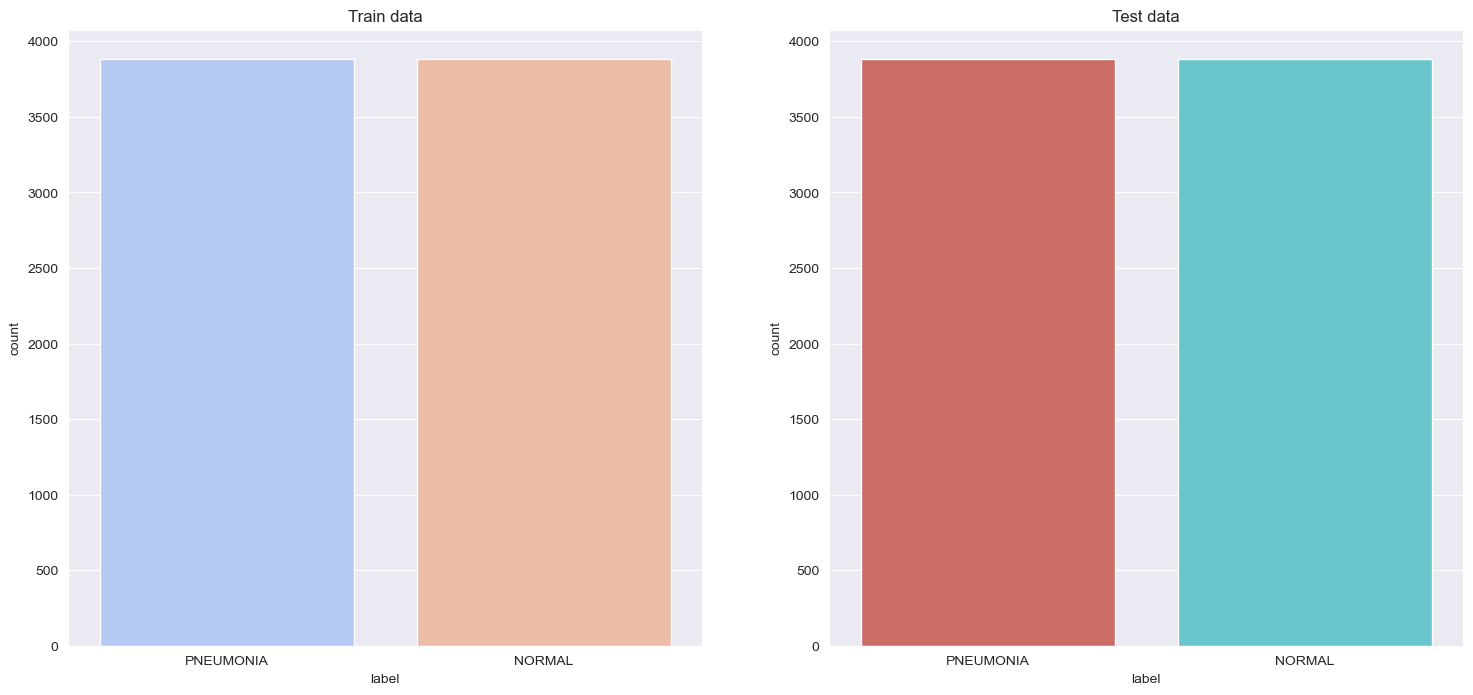

In [7]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

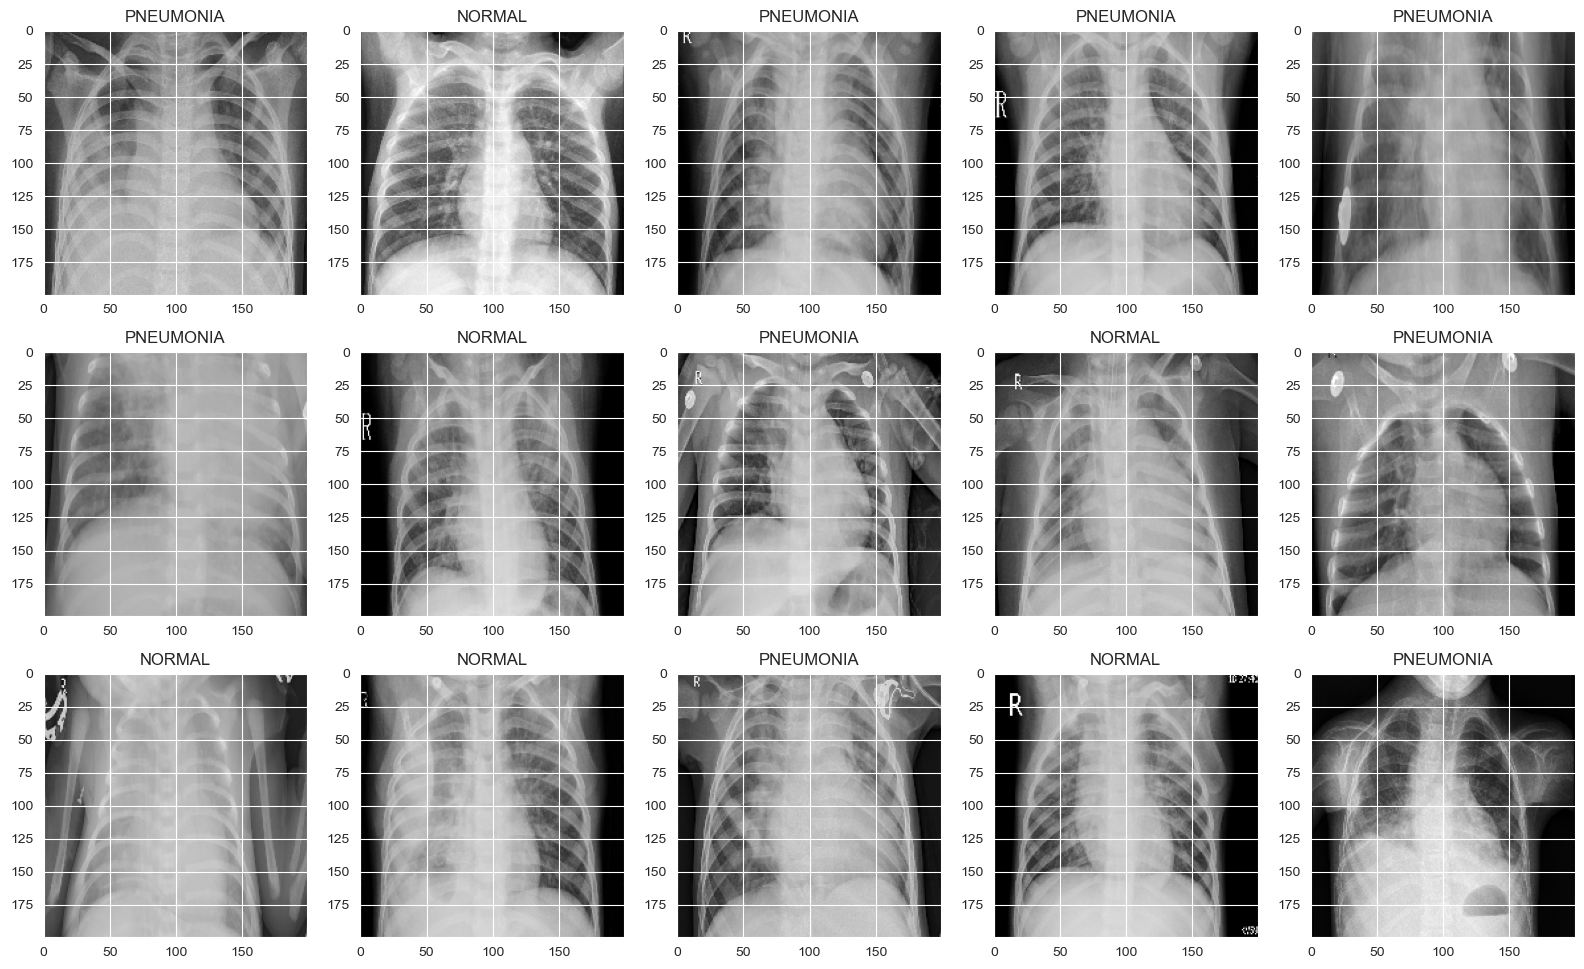

In [8]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

In [9]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [10]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [11]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [12]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [13]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [14]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    data1 = data1.repeat(3, axis=-1)
    return data1

In [15]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=42)

In [17]:
num_classes = y_train.shape[1]

In [18]:
input_shape = (img_size, img_size, 1)

In [19]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [20]:
callbacks4 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('../working/model.best4.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [21]:
base_model_resnet = keras.applications.ResNet50(weights="imagenet",include_top=False) 
for each_layer in base_model_resnet.layers:
    each_layer.trainable = False
    
base_model_resnet.trainable = False
inputs = keras.Input(shape=(200, 200,3))   
x = base_model_resnet(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)    
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)      
output = keras.layers.Dense(num_classes, activation = "softmax")(x)

In [22]:
resnet_model = keras.Model(inputs, output)
resnet_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [23]:
learning_history = resnet_model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks4,
                        )

C:\Users\vasuk\AppData\Local\Temp\ipykernel_2384\1718007840.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history = resnet_model.fit_generator((train_gen),


Epoch 1/100
182/182 [==============================] - 356s 2s/step - loss: 0.8270 - accuracy: 0.4981 - val_loss: 11.8524 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 2/100
182/182 [==============================] - 377s 2s/step - loss: 0.7447 - accuracy: 0.4952 - val_loss: 306.5919 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 3/100
182/182 [==============================] - 366s 2s/step - loss: 0.7190 - accuracy: 0.4897 - val_loss: 403.7404 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 4/100
182/182 [==============================] - 365s 2s/step - loss: 0.7031 - accuracy: 0.5034 - val_loss: 184.6719 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 5/100
182/182 [==============================] - 364s 2s/step - loss: 0.7002 - accuracy: 0.5007 - val_loss: 275.5164 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 6/100
182/182 [==============================] - 373s 2s/step - loss: 0.6966 - accuracy: 0.4962 - val_loss: 193.7593 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 7/100
182/182 [==========================

In [24]:
resnet_model.save('pretrained.h5')

In [25]:
model = tf.keras.models.load_model('pretrained.h5')

In [26]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 1192.5278663635254%
Test accuracy: 50.0%
MLP Error: 50.00%


In [27]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

243/243 [==============================] - 353s 1s/step


In [28]:
y_pre_test = np.argmax(y_test, axis = 1)

In [29]:
def show_condition(num):
    if num == 0:
        return 'NORMAL'
    return 'PNEUMONIA'

C:\Users\vasuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


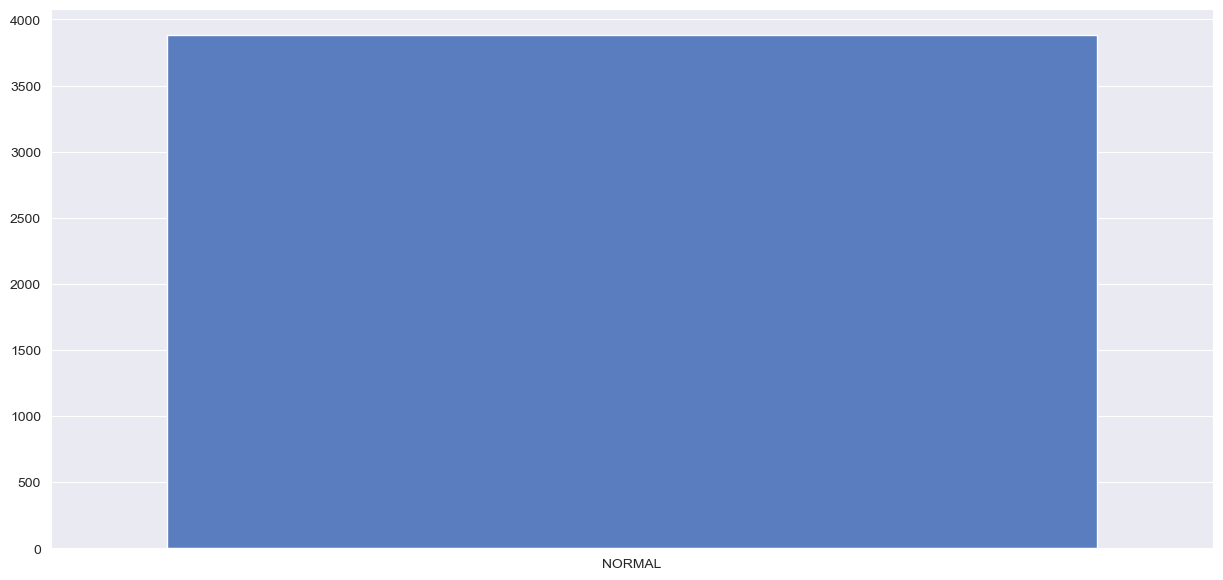

In [30]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if a == b: continue
    cnt_error.append(a)# test

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
sns.barplot([show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
plt.show()

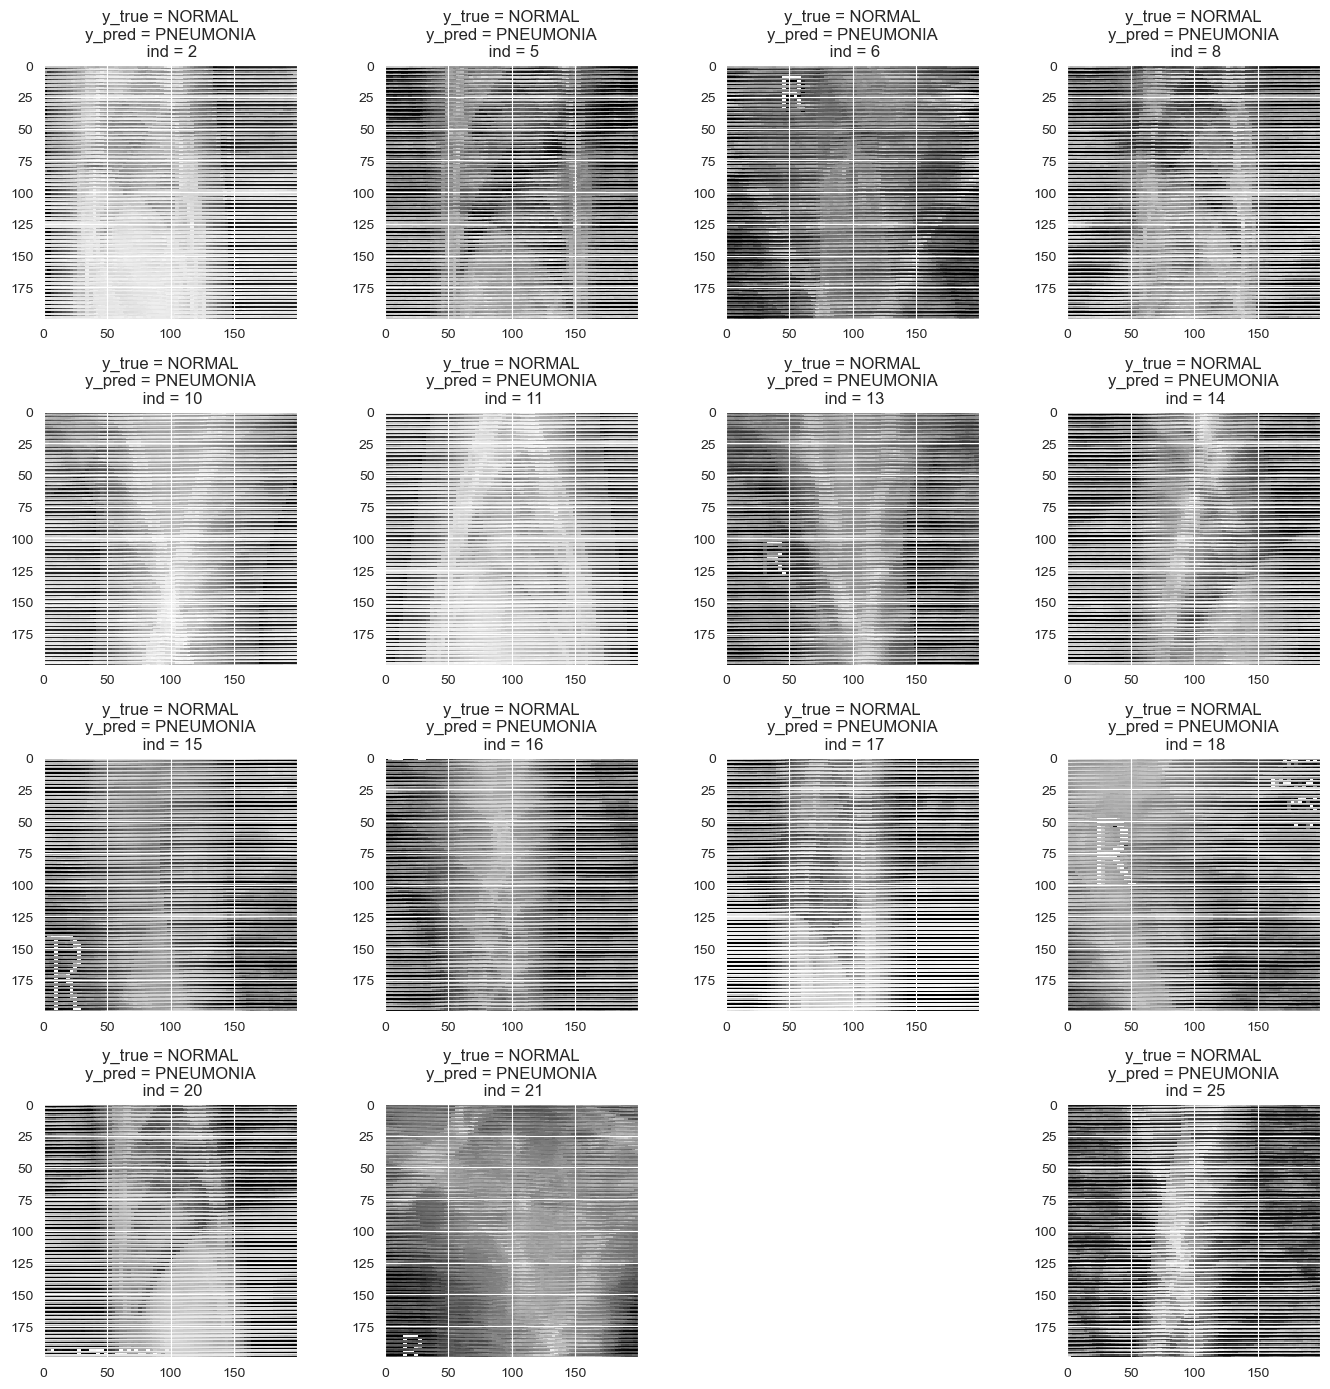

In [31]:
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1

In [32]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3883
           1       0.50      1.00      0.67      3883

    accuracy                           0.50      7766
   macro avg       0.25      0.50      0.33      7766
weighted avg       0.25      0.50      0.33      7766



C:\Users\vasuk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vasuk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vasuk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score
precision = precision_score(y_pre_test, y_pred)
recall = recall_score(y_pre_test, y_pred)
f1score = f1_score(y_pre_test, y_pred)
acc = accuracy_score(y_pre_test,y_pred)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")
print(f"Accuracy = {acc}")

Precision = 0.5
Recall = 1.0
F1 Score = 0.6666666666666666
Accuracy = 0.5


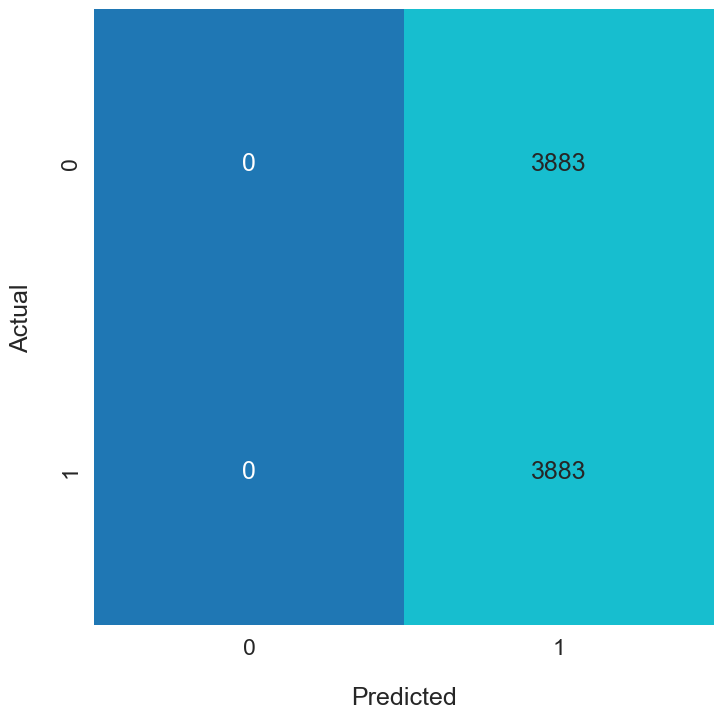

In [34]:
conf_matrix = confusion_matrix(y_pre_test, y_pred)

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()